Interactively test the spherical Voronoi algorithm implementation proposed by Ross Hemsley at PyData London 2015

In [62]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
import voronoi_utility
import numpy as np
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
#pre-requisite step: generate the random coordinates on the sphere
prng = np.random.RandomState(117)
random_coordinate_array = voronoi_utility.generate_random_array_spherical_generators(1000,1.0,prng)

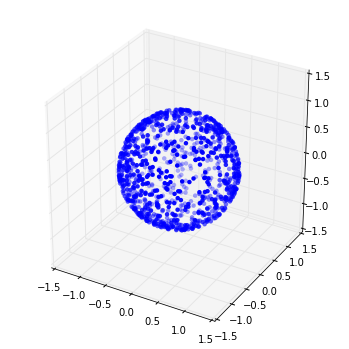

In [64]:
#confirm reasonable distribution of points on the unit sphere
fig_initial_sphere = plt.figure()
ax = fig_initial_sphere.add_subplot('111', projection = '3d')
ax.scatter(random_coordinate_array[...,0], random_coordinate_array[...,1], random_coordinate_array[...,2], c = 'blue', edgecolor = 'none')
fig_initial_sphere.set_size_inches(6,6)

In [65]:
#step 1: place an additional generator at the centre of the sphere (the origin of the coordinate system)
random_coordinate_array = np.concatenate((random_coordinate_array, np.zeros((1,3))))
random_coordinate_array[-5:,...]

array([[ 0.81325255, -0.10395777, -0.57254962],
       [ 0.45141247, -0.58900654,  0.67029701],
       [-0.629159  , -0.77472842, -0.06288739],
       [-0.44992442,  0.10452284,  0.88692897],
       [ 0.        ,  0.        ,  0.        ]])

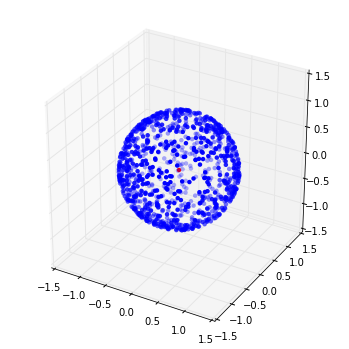

In [66]:
#confirm appropriate coordinates for the center (in red)
fig_additional_generator = plt.figure()
ax = fig_additional_generator.add_subplot('111', projection = '3d')
ax.scatter(random_coordinate_array[:-1,0], random_coordinate_array[:-1,1], random_coordinate_array[:-1,2], c = 'blue', edgecolor = 'none')
ax.scatter(random_coordinate_array[-1,0], random_coordinate_array[-1,1], random_coordinate_array[-1,2], c = 'red', edgecolor = 'none')
fig_additional_generator.set_size_inches(6,6)

In [67]:
#step 2: perform 3D Delaunay triangulation on data set that includes the extra generator
tri = sp.spatial.Delaunay(random_coordinate_array)

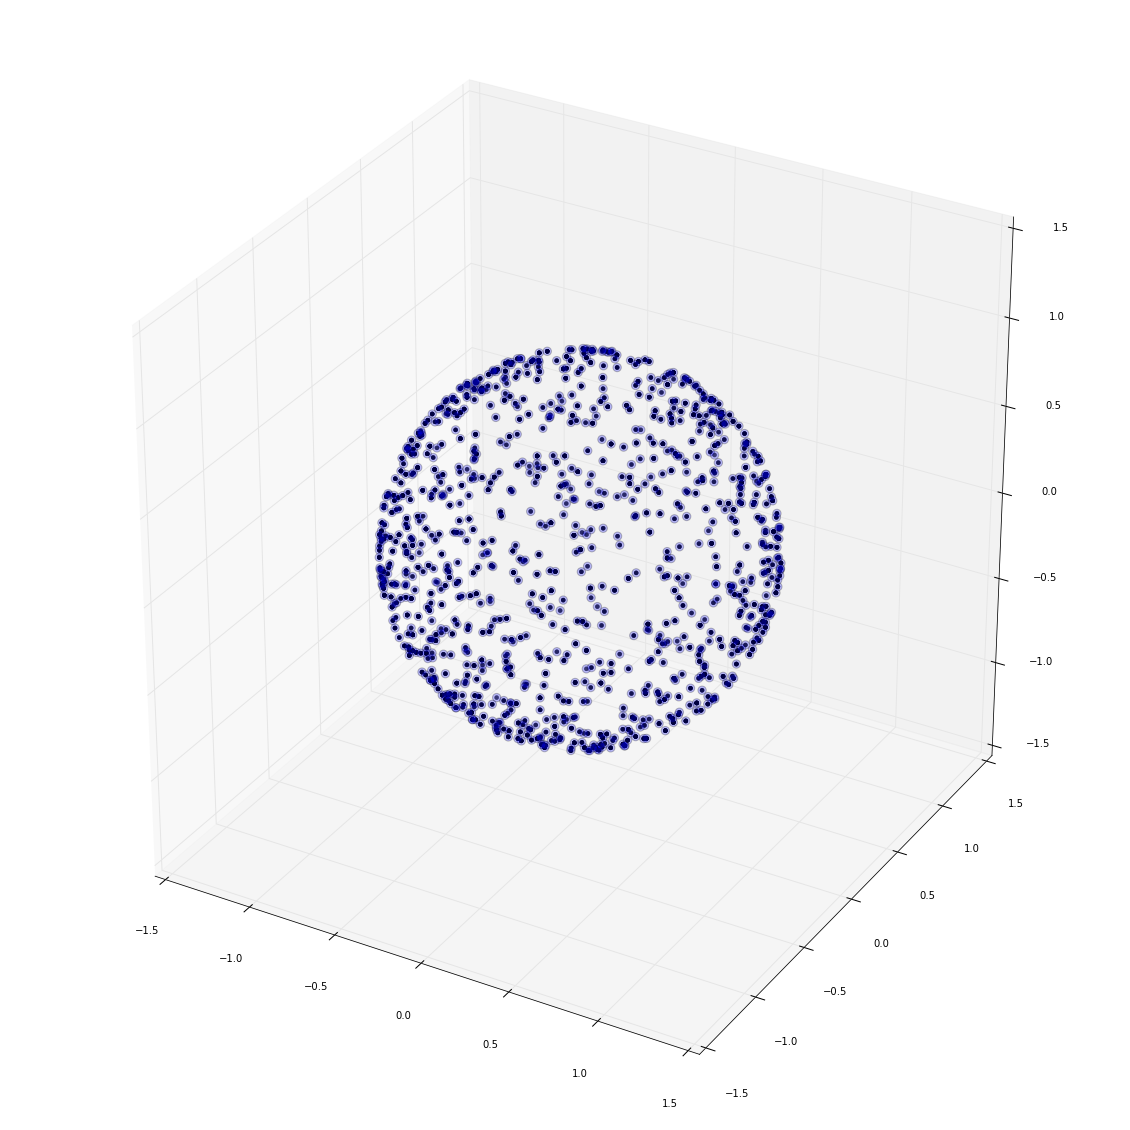

In [68]:
#confirm reasonable-looking tetrahedralization of sphere
fig_initial_tetrahedralization = plt.figure()
ax = fig_initial_tetrahedralization.add_subplot('111', projection = '3d')
for simplex in tri.points[tri.simplices]:
    ax.scatter(simplex[...,0], simplex[...,1], simplex[...,2], c = 'k', edgecolor = 'none')
ax.scatter(random_coordinate_array[...,0], random_coordinate_array[...,1], random_coordinate_array[...,2], c = 'blue', edgecolor = 'none', s = 70, alpha = 0.25)
fig_initial_tetrahedralization.set_size_inches(20,20)

Although connecting the tetrahedra in a non-intersecting fashion would probably be a bit more work, the superposition of generators on the tetrahedral vertices is sensible given that each generator should indeed be a vertex in the 3D tetrahedralization.

In [87]:
#step 3a: produce circumspheres / circumcenters of tetrahedra from 3D Delaunay
#based on some rough testing, it turns out that ALL simplices (tetrahedra) have one vertex at the origin [I think Ross was trying to explain this to me at PyData London 2015]
#the unit normal to the outer Delaunay facet (on sphere surface) is a Voronoi vertex (as in my previous algorithm)
#because each tetrahedron contains the origin as a vertex, the circumcenter is located halfway between the origin and the Voronoi vertex [othwerise the other vertices would illegally be located inside the circumsphere]
#furthermore, if we exclude the tetrahedral vertex at the origin, the remaining three vertices form a face (triangle) on the sphere surface, the circumcenter of which may be projected to the sphere surface to produce the coordinates of the corresponding Voronoi vertex

import circumcircle

list_circumcenter_coordinates = []
for simplex in tri.points[tri.simplices]: #iterate over tetrahedra
    #need to find circumcenter of tetrahedron circumsphere
    tetrahedron_circumsphere_circumcenter = circumcircle.calc_circumcenter_circumsphere_tetrahedron(simplex)
    list_circumcenter_coordinates.append(tetrahedron_circumsphere_circumcenter)
    
array_circumcenter_coords = np.array(list_circumcenter_coordinates)
    
    
    

In [88]:
array_circumcenter_coords.shape

(1996, 3)

In [89]:
array_circumcenter_coords

array([[ -2.69205913,   0.61915845,   3.69057725],
       [ -3.30602206, -14.08537079,  14.39349578],
       [ 11.73609748,   0.83445737,  10.99822348],
       ..., 
       [  7.93195712, -29.03554604, -27.34769646],
       [  6.88259467,   6.38778736,   6.88063569],
       [ -1.28780106,   6.9777577 ,   6.87330334]])

In [94]:
#I'm pretty sure the circumcenter coords should fall within the unit sphere because the circumsphere of the simplex should not contain any generators
#do some isolated plotting to test this out [looks like above circumcenter coords are wrong at the moment?]

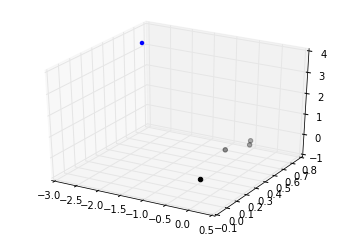

In [96]:
first_tetrahedron = tri.points[tri.simplices][0]
first_tetrahedron
first_circumcenter = circumcircle.calc_circumcenter_circumsphere_tetrahedron(first_tetrahedron)
fig_test_circumcenter = plt.figure()
ax = fig_test_circumcenter.add_subplot('111', projection = '3d')
ax.scatter(first_tetrahedron[...,0], first_tetrahedron[...,1], first_tetrahedron[...,2], c = 'k')
ax.scatter(first_circumcenter[...,0], first_circumcenter[...,1], first_circumcenter[...,2], c= 'blue', edgecolor = 'none')

In [98]:
#so, something must be wrong with the circumsphere / circumcenter calculation at the moment (because circumcenter is showing up outside the unit sphere)